In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode
import scipy as sp

import bambi
import pymc3 as pm
import arviz as az

from seaborn import despine
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

from utils.plotting import cm2inch, violin, add_ttest
from utils.descriptives import aggregate_subject_level_data
from utils.stats import get_var, compute_ttests, sample_corr
from utils.general import make_sure_path_exists

# Descriptives & data

In [2]:
setsizes = np.array([9, 16, 25, 36])
n_setsizes = setsizes.size

subjects = np.arange(49)
n_subjects = subjects.size

# indicators for set sizes
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']
markers = ['o', '^', 's', 'D']

# define model names
model_names = ['probabilistic_satisficing', 'independent_accumulation', 'GLAM']
model_titles = ['PSM', 'IAM', 'GLAM']
gaze_bias_states = ['with_active_gaze', 'with_passive_gaze']

mfx_dir = 'results/posterior_traces/mixed_effects_models/'
# make sure output dir exists
for model_name in model_names:
    for gaze_bias in gaze_bias_states:
        make_sure_path_exists('results/predictions/{}_{}/'.format(model_name, gaze_bias))
        make_sure_path_exists('results/posterior_traces/{}_{}/'.format(model_name, gaze_bias))
        make_sure_path_exists('results/waic/{}_{}/'.format(model_name, gaze_bias))

# Figure 6

In [3]:
def get_aggregate_data(model_name, subjects=np.arange(49), setsizes=np.array([9,16,25,36]), seed=1):
    
    mfx_data = []
    mfx_model = []
    for si, setsize  in enumerate(setsizes):

        # load data
        data = pd.read_csv('data/summary_files/{}_data.csv'.format(setsize))
        model_pred = []
        for subject in subjects:
            sub_filepath = 'results/predictions/{}/{}_{}_prediction.csv'.format(model_name, subject, setsize)
            if os.path.isfile(sub_filepath):
                model_pred_subject = pd.read_csv(sub_filepath)
                model_pred_subject['setsize'] = setsize
                model_pred.append(model_pred_subject)
        model_pred = pd.concat(model_pred)

        # aggregate subject level RT, p(choose best), gaze influence
        np.random.seed(seed)
        subject_aggregate_data = aggregate_subject_level_data(data, n_items=setsize)
        subject_aggregate_model = aggregate_subject_level_data(model_pred, n_items=setsize)
        
        # collect aggregates
        mfx_data.append(pd.DataFrame({'subject': subjects,
                                      'setsize': setsize,
                                      'obs_rt': subject_aggregate_data['rt']['mean'],
                                      'obs_p_choose_best': subject_aggregate_data['best_chosen']['mean']*100,
                                      'obs_gaze_influence': subject_aggregate_data['gaze_influence']*100,
                                      'pred_rt': subject_aggregate_model['rt']['mean'],
                                      'pred_p_choose_best': subject_aggregate_model['best_chosen']['mean']*100,
                                      'pred_gaze_influence': subject_aggregate_model['gaze_influence']*100}))
        
    return pd.concat(mfx_data)

In [4]:
def _scatter(x, y, ax, color, marker, label=None):
    ax.scatter(x, y, marker=marker, color='none', edgecolor=color, 
               linewidth=0.75, alpha=1, s=20)
    ax.scatter(x, y, marker=marker, color=color, alpha=0.35,
               linewidth=0, s=20, label=label)
    return ax



----
PSM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -138.0684312204463, 94% HPD: -413.57036253473956, 118.53511882674788
obs_rt[0]; Mean: 1.0051940892498563, 94% HPD: 0.9535573125798792, 1.0506871678899965

p-choose-best:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -1.9039269323879036, 94% HPD: -7.63733422379354, 3.1855377733776407
obs_p_choose_best[0]; Mean: 0.8494499203878675, 94% HPD: 0.785322407575398, 0.9119836928077358

gaze-influence:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 7.025388804079434, 94% HPD: 4.949532667992736, 10.23416740773389
obs_gaze_influence[0]; Mean: 0.4829143432417526, 94% HPD: 0.3754469187170434, 0.5575009471196029


----
IAM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -1184.8837096725015, 94% HPD: -2292.898959374832, -61.35107353257668
obs_rt[0]; Mean

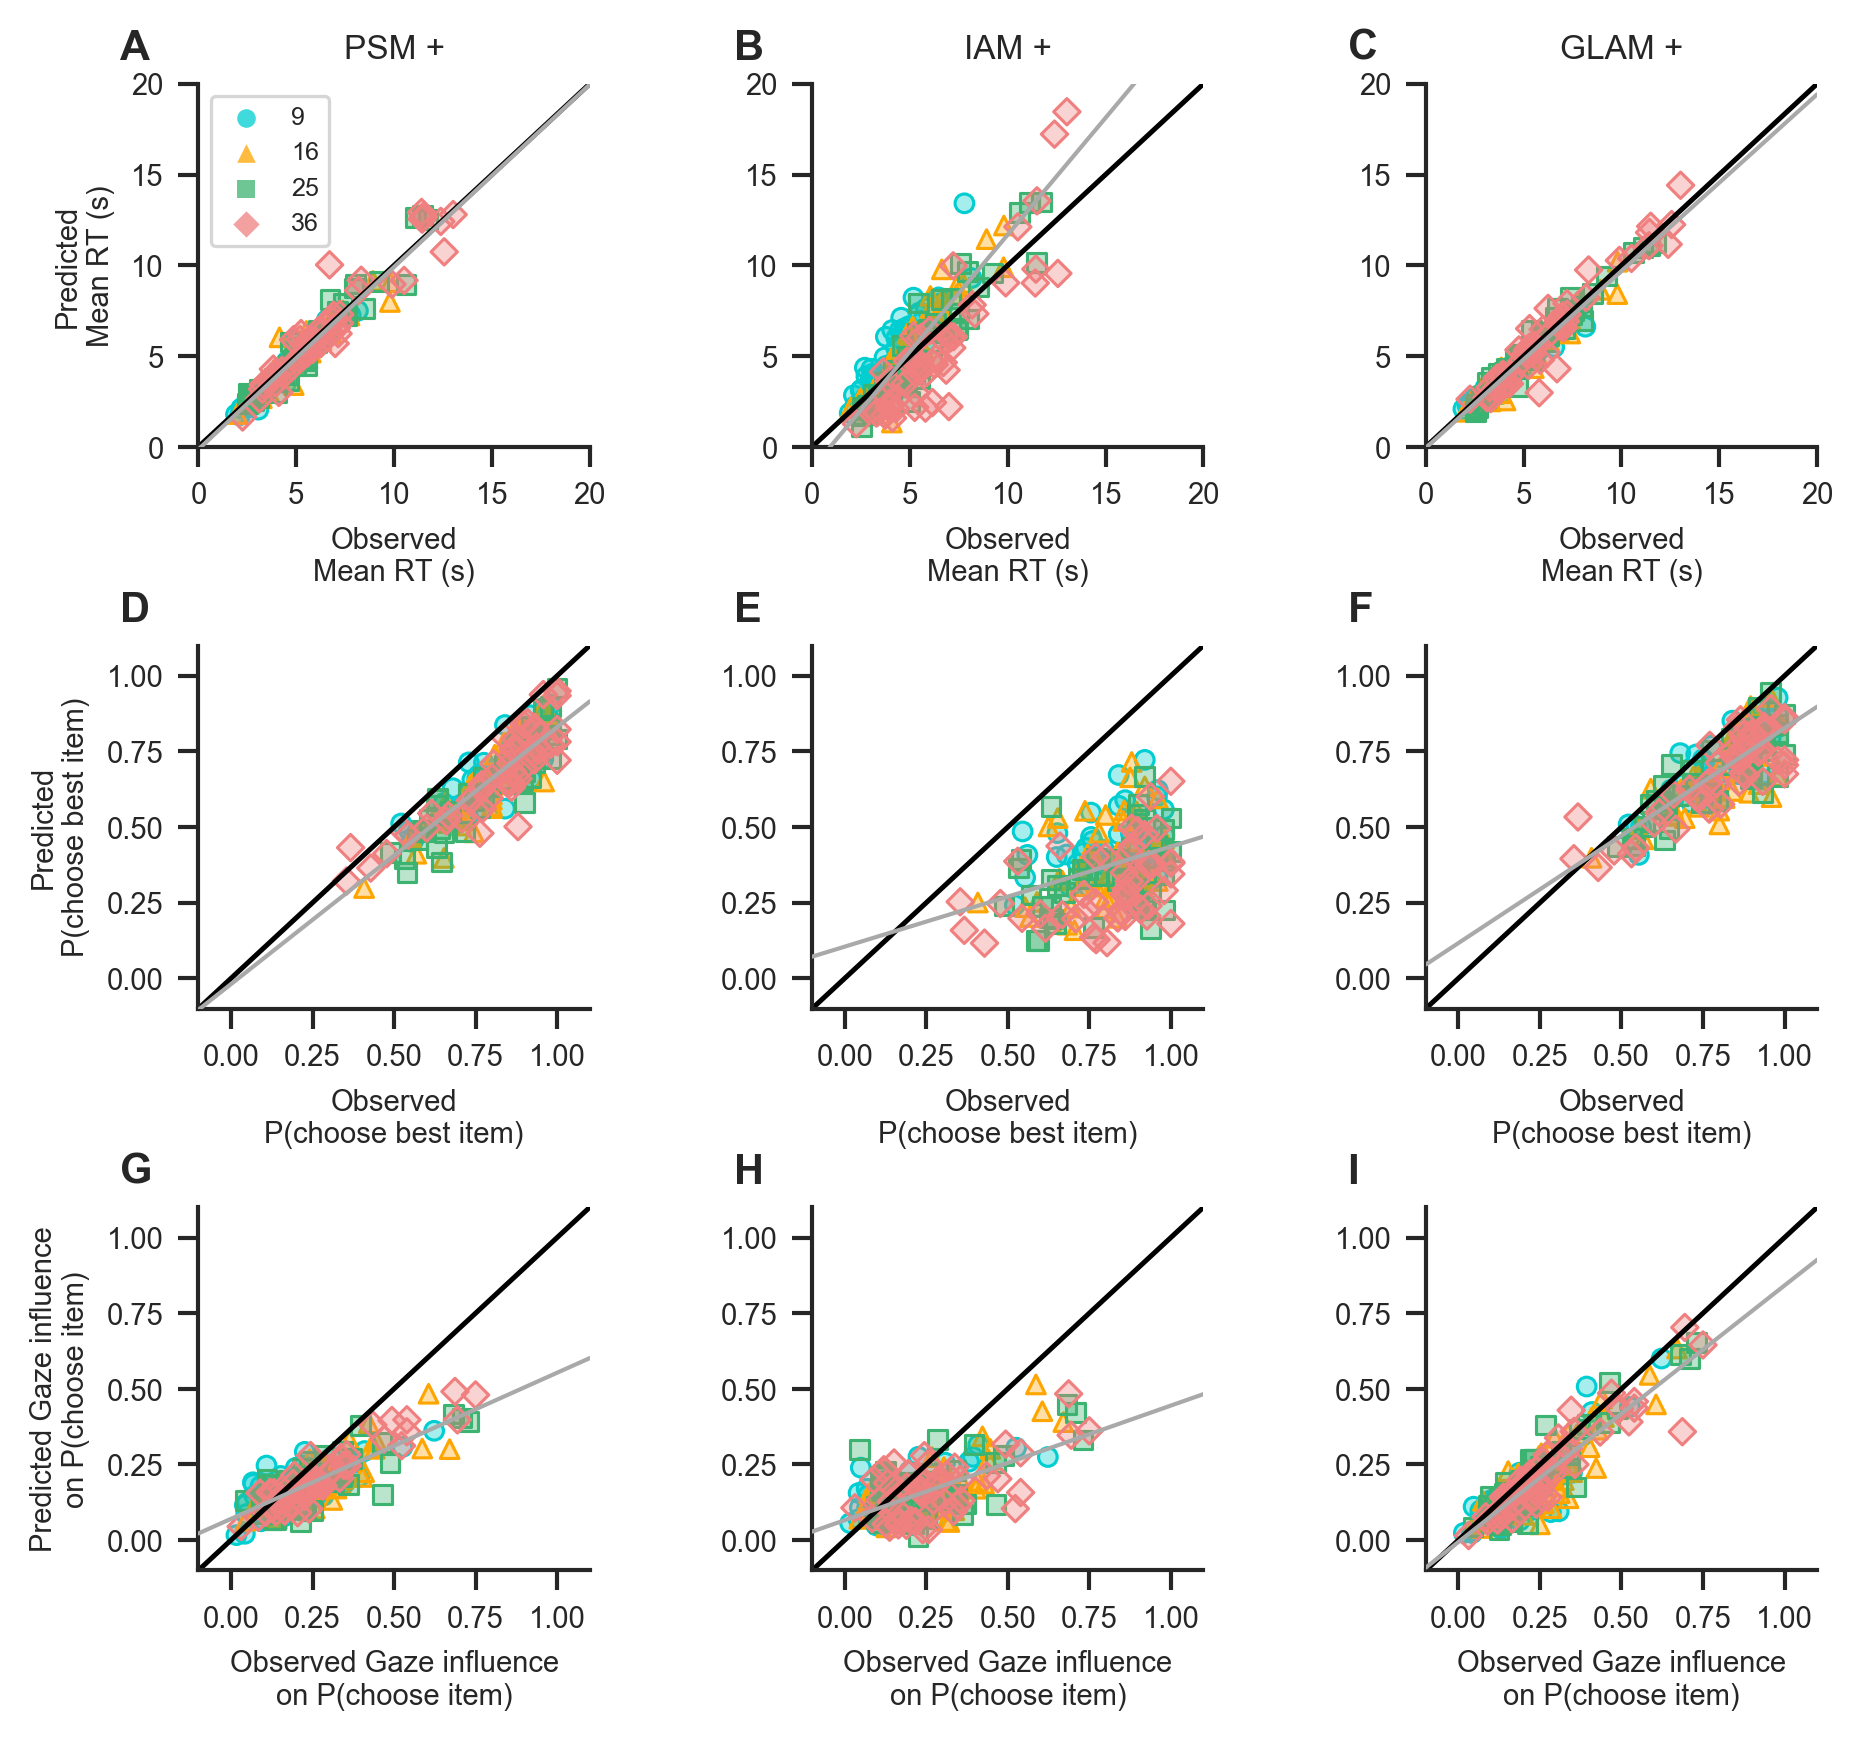

In [5]:
np.random.seed(2438)
seed = 2438

# only models with active gaze influence
gaze_bias = 'with_active_gaze'

# make fig
fig, axs = plt.subplots(3,3,figsize=cm2inch(16,15), dpi=300)

for model_i, (model_name, model_label) in enumerate(zip(
    ['probabilistic_satisficing', 'independent_accumulation', 'GLAM'],
    ['PSM +', 'IAM +', 'GLAM +'])):
    
    # add title
    axs[0,model_i].set_title(model_label, fontsize=8)
    print('\n\n----\n{}'.format(model_label))
    
    # get aggregate data
    mfx_data = get_aggregate_data('{}_{}'.format(model_name, gaze_bias))
    
    # iterate metrics
    for metric_i, metric in enumerate(['rt', 'p_choose_best', 'gaze_influence']):
        print('\n{}:'.format('-'.join(metric.split('_'))))
        
        # plot results
        for si, setsize in enumerate(setsizes):
            # subset
            mfx_data_setsize = mfx_data[mfx_data['setsize']==setsize].copy() 
                        
            # mean RT
            if 'rt' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 1000,
                                         mfx_data_setsize['pred_{}'.format(metric)].values / 1000,
                                                  marker=markers[si],
                                         ax=axs[metric_i,model_i],
                                         color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(0, 20)
                axs[metric_i,model_i].set_xlim(0, 20)
                axs[metric_i,model_i].set_xticks(np.array([0,5,10,15,20]))
                axs[metric_i,model_i].set_yticks(np.array([0,5,10,15,20]))
                axs[metric_i,model_i].set_xticklabels(np.array([0,5,10,15,20]), fontsize=7)
                axs[metric_i,model_i].set_yticklabels(np.array([0,5,10,15,20]), fontsize=7)
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nMean RT (s)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nMean RT (s)', fontsize=7)
            
            # mean p(choose best)
            elif 'p_choose_best' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                 mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                 ax=axs[metric_i,model_i],
                                                 color=colors[si])
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nP(choose best item)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nP(choose best item)', fontsize=7)
            
            # mean gaze influence
            else:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                  mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                  ax=axs[metric_i,model_i],
                                                  color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted Gaze influence\non P(choose item)', fontsize=7)  
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed Gaze influence\non P(choose item)', fontsize=7)

                            
        # compute mfx-regression fit
        mfx_filename = '{}_observed-predicted_{}-{}_mfx'.format('-'.join(metric.split('_')),
                                                                '-'.join(model_name.split('_')),
                                                                '-'.join(gaze_bias.split('_')))
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            converged = False
            tries = 1
            while not converged:
                # make model
                samples = 2000
                burn = 500
                model = bambi.Model(data=mfx_data)
                model.add('pred_{} ~ obs_{}'.format(metric, metric),
                          random=['1+obs_{}|setsize'.format(metric)],
                          categorical=['setsize'])
                # sample posterior
                results = model.fit(samples=samples,
                                    tune=burn*tries,
                                    chains=2,
                                    backend='pymc',
                                    init='ADVI',
                                    n_init=50000,
                                    random_seed=seed)
                # save results
                pm.trace_to_dataframe(model.backend.trace).to_csv(
                    mfx_dir+mfx_filename+'_mtrace.csv', index=False)
                az.plot_trace(results)
                plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
                summary = az.summary(results, round_to='none')
                summary.to_csv(mfx_dir+mfx_filename+'.csv')
                # check convergence
                if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
                   (np.abs(summary.loc['obs_{}[0]'.format(metric), 'r_hat'] - 1) <= 0.05):
                    converged = True
                tries += 1
        else:
            print('Loading mfx-summary from '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
        b0,_ = get_var(summary, 'Intercept[0]')
        b1,_ = get_var(summary, 'obs_{}[0]'.format(metric))
        seed += 1
        # add regression line
        if 'rt' in metric:
            xs = np.linspace(0,20,100)
            axs[metric_i,model_i].plot(xs, (b0/1000)+(b1*xs), color='darkgray', lw=1, zorder=99)
        else:
            xs = np.linspace(-0.1,1.1,100)
            axs[metric_i,model_i].plot(xs, (b0/100)+(b1*xs), color='darkgray', lw=1, zorder=99)
        # add diagonal
        axs[metric_i,model_i].plot(xs, xs, color='k')
    

# add panel indicators
for ax, label in zip(axs.ravel(), list('ABCDEFGHIJKLMNOPQR')):
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.text(-0.2, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    despine(ax=ax)

# add legend
leg = axs[0,0].legend(loc='upper left', fontsize=6)
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)

# save
fig.tight_layout(h_pad=0, w_pad=3)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.pdf', dpi=300)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.png', dpi=300)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.jpg', dpi=300)

## .. and for model variants with passive gaze



----
PSM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -220.336728537312, 94% HPD: -407.79823831433913, -2.379297781001517
obs_rt[0]; Mean: 0.9999091530190912, 94% HPD: 0.946325645664166, 1.0581083918989185

p-choose-best:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 9.871467113392944, 94% HPD: 4.859011747691453, 14.62057081270476
obs_p_choose_best[0]; Mean: 0.7546775342855224, 94% HPD: 0.6933244615611247, 0.8064937144009949

gaze-influence:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 7.242128848170488, 94% HPD: 4.715635173663054, 9.778383941297301
obs_gaze_influence[0]; Mean: 0.17949091120774952, 94% HPD: 0.06758959263384118, 0.2802127396137112


----
IAM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -679.0451478965371, 94% HPD: -1942.7449833315234, 405.4390679127797
obs_rt[0]; Mean: 1

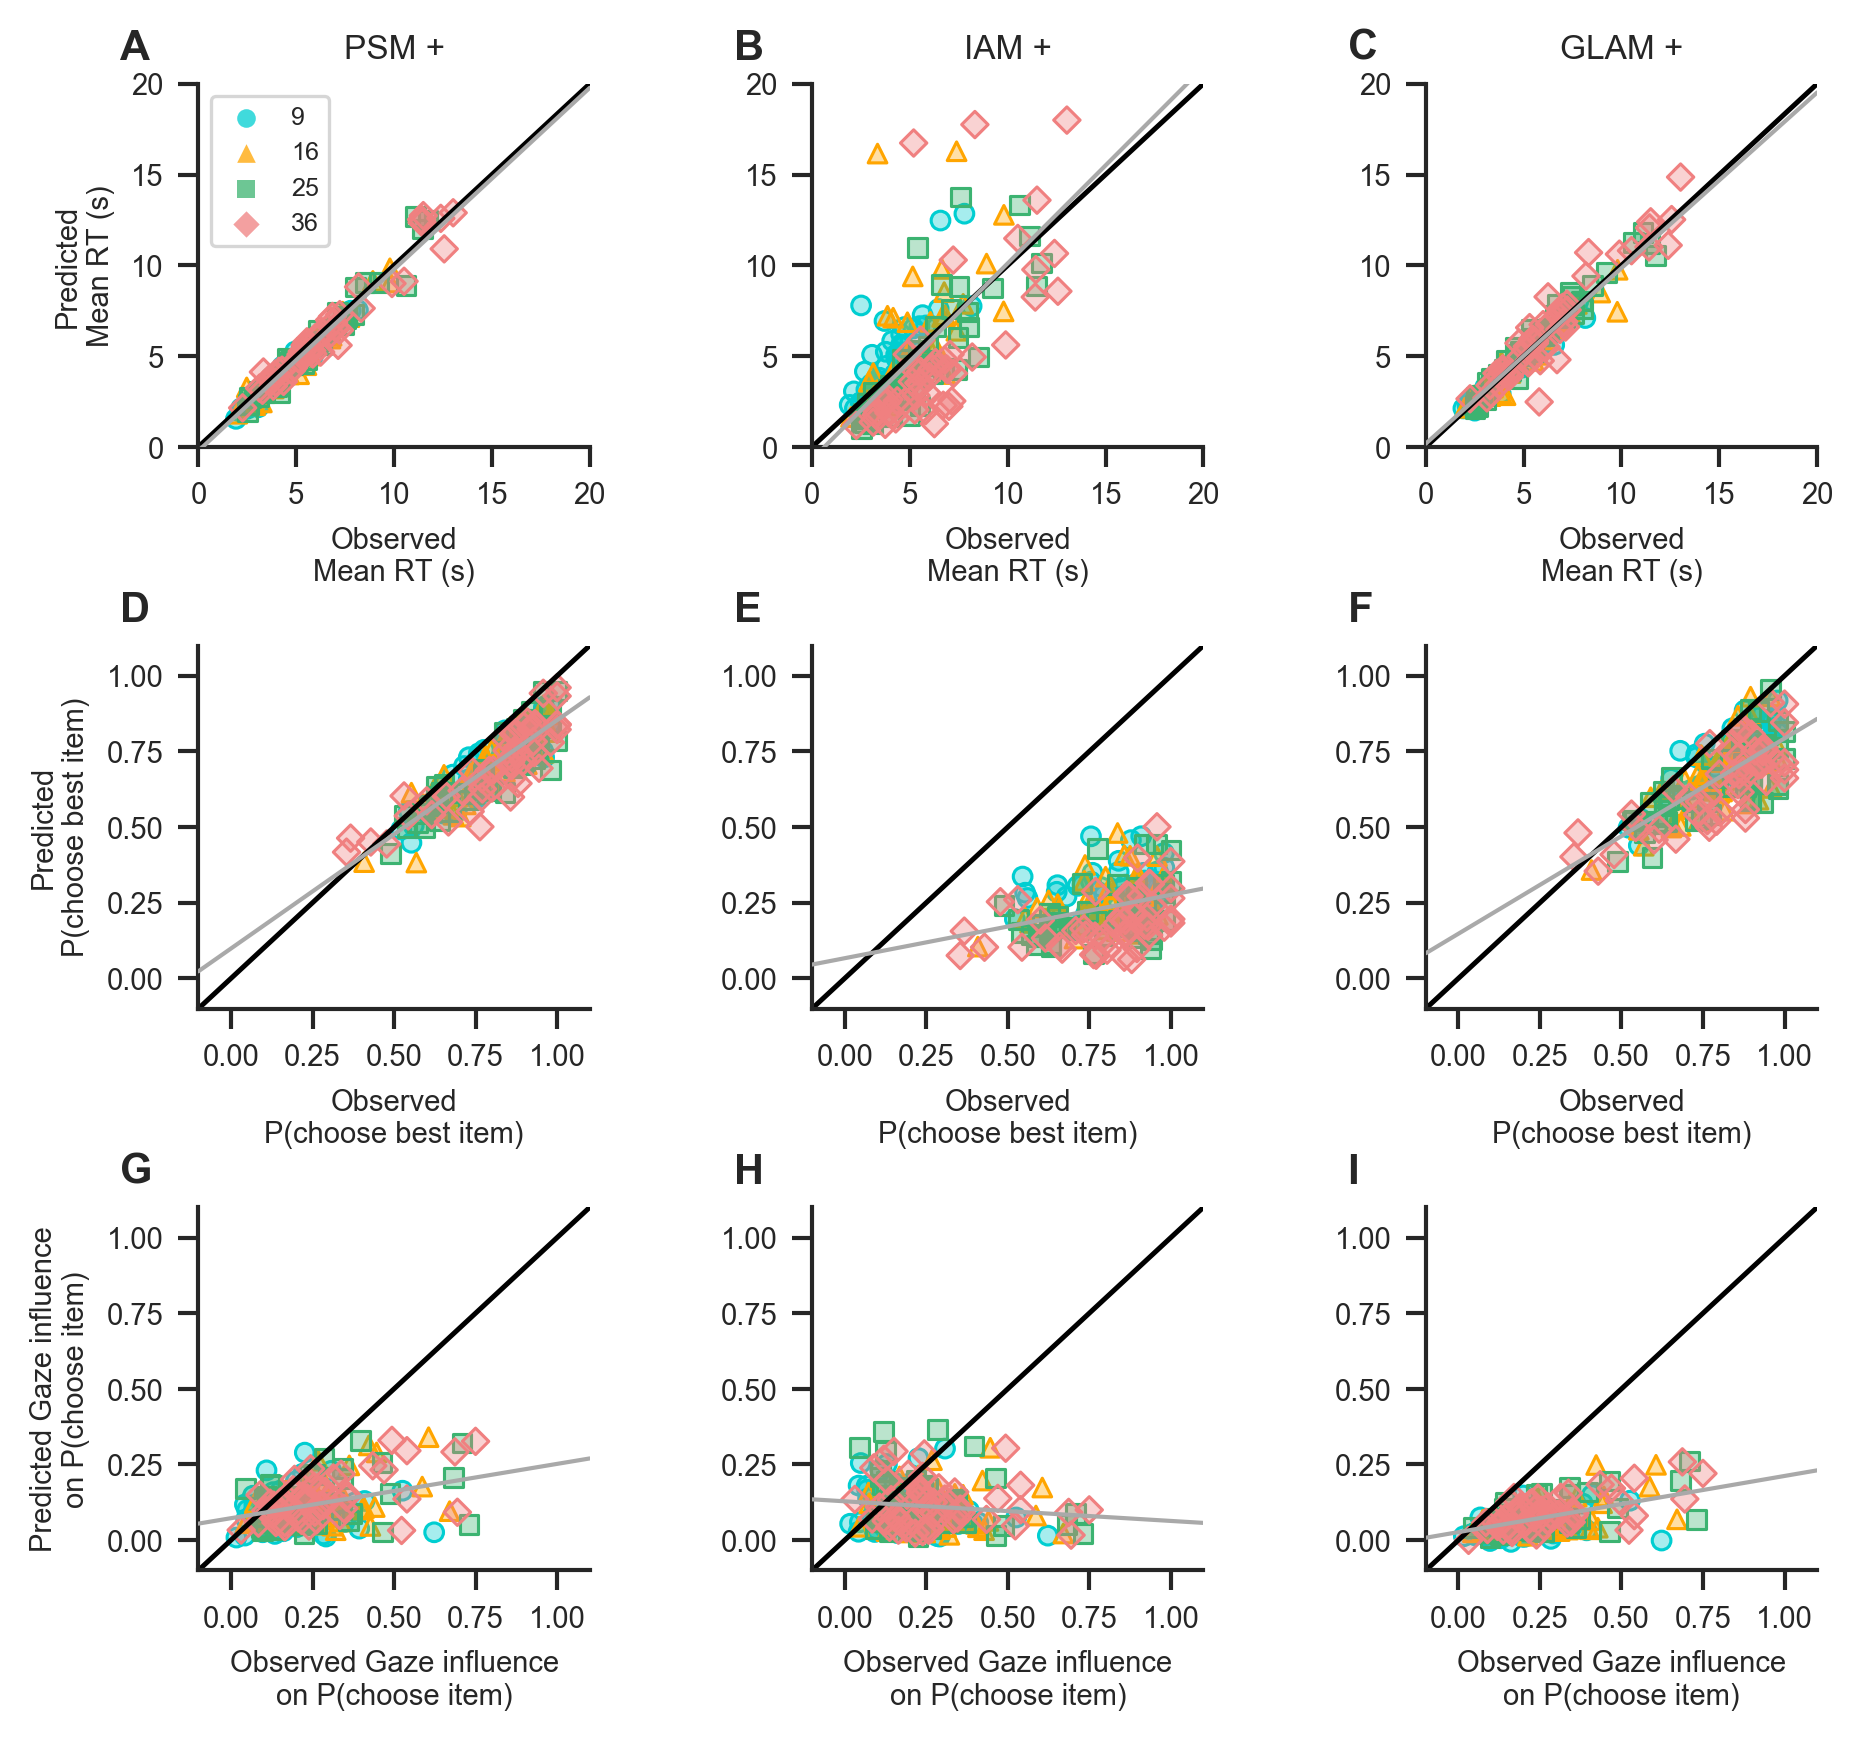

In [6]:
np.random.seed(2438)
seed = 2438

# only models with passive gaze
gaze_bias = 'with_passive_gaze'

# make fig
fig, axs = plt.subplots(3,3,figsize=cm2inch(16,15), dpi=300)

for model_i, (model_name, model_label) in enumerate(zip(
    ['probabilistic_satisficing', 'independent_accumulation', 'GLAM'],
    ['PSM +', 'IAM +', 'GLAM +'])):
    
    # add title
    axs[0,model_i].set_title(model_label, fontsize=8)
    print('\n\n----\n{}'.format(model_label))
    
    # get aggregate data
    mfx_data = get_aggregate_data('{}_{}'.format(model_name, gaze_bias))
    
    # iterate metrics
    for metric_i, metric in enumerate(['rt', 'p_choose_best', 'gaze_influence']):
        print('\n{}:'.format('-'.join(metric.split('_'))))
        
        
        # scatter
        for si, setsize in enumerate(setsizes):
            # subset
            mfx_data_setsize = mfx_data[mfx_data['setsize']==setsize].copy()            
            # scatter
            if 'rt' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 1000,
                                         mfx_data_setsize['pred_{}'.format(metric)].values / 1000,
                                                  marker=markers[si],
                                         ax=axs[metric_i,model_i],
                                         color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(0, 20)
                axs[metric_i,model_i].set_xlim(0, 20)
                axs[metric_i,model_i].set_xticks(np.array([0,5,10,15,20]))
                axs[metric_i,model_i].set_yticks(np.array([0,5,10,15,20]))
                axs[metric_i,model_i].set_xticklabels(np.array([0,5,10,15,20]), fontsize=7)
                axs[metric_i,model_i].set_yticklabels(np.array([0,5,10,15,20]), fontsize=7)
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nMean RT (s)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nMean RT (s)', fontsize=7)
            elif 'p_choose_best' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                 mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                 ax=axs[metric_i,model_i],
                                                 color=colors[si])
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nP(choose best item)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nP(choose best item)', fontsize=7)
            else:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                  mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                  ax=axs[metric_i,model_i],
                                                  color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted Gaze influence\non P(choose item)', fontsize=7)  
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed Gaze influence\non P(choose item)', fontsize=7)

                
        # mfx regression
        mfx_filename = '{}_observed-predicted_{}-{}_mfx'.format('-'.join(metric.split('_')),
                                                                '-'.join(model_name.split('_')),
                                                                '-'.join(gaze_bias.split('_')))
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            converged = False
            tries = 1
            while not converged:
                # make model
                samples = 2000
                burn = 500
                model = bambi.Model(data=mfx_data)
                model.add('pred_{} ~ obs_{}'.format(metric, metric),
                          random=['1+obs_{}|setsize'.format(metric)],
                          categorical=['setsize'])
                # sample posterior
                results = model.fit(samples=samples,
                                    tune=burn*tries,
                                    chains=2,
                                    backend='pymc',
                                    init='ADVI',
                                    n_init=50000,
                                    random_seed=seed)
                # save results
                pm.trace_to_dataframe(model.backend.trace).to_csv(
                    mfx_dir+mfx_filename+'_mtrace.csv', index=False)
                az.plot_trace(results)
                plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
                summary = az.summary(results, round_to='none')
                summary.to_csv(mfx_dir+mfx_filename+'.csv')
                # check convergence
                if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
                   (np.abs(summary.loc['obs_{}[0]'.format(metric), 'r_hat'] - 1) <= 0.05):
                    converged = True
                tries += 1
        else:
            print('Loading mfx-summary from '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
        b0,_ = get_var(summary, 'Intercept[0]')
        b1,_ = get_var(summary, 'obs_{}[0]'.format(metric))
        seed += 1
        # add regression line
        if 'rt' in metric:
            xs = np.linspace(0,20,100)
            axs[metric_i,model_i].plot(xs, (b0/1000)+(b1*xs), color='darkgray', lw=1, zorder=99)
        else:
            xs = np.linspace(-0.1,1.1,100)
            axs[metric_i,model_i].plot(xs, (b0/100)+(b1*xs), color='darkgray', lw=1, zorder=99)
        # add diagonal
        axs[metric_i,model_i].plot(xs, xs, color='k')
    

# add panel indicators
for ax, label in zip(axs.ravel(), list('ABCDEFGHIJKLMNOPQR')):
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.text(-0.2, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    despine(ax=ax)

# add legend
leg = axs[0,0].legend(loc='upper left', fontsize=6)
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)

# save
fig.tight_layout(h_pad=0, w_pad=3)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.pdf', dpi=300)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.png', dpi=300)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.jpg', dpi=300)